In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/text-augmented/review_aug_insert.csv
/kaggle/input/text-augmented/review_aug_sub.csv
/kaggle/input/text-augmented/test_aug_insert.csv
/kaggle/input/text-augmented/test_aug_sub.csv
/kaggle/input/student-shopee-code-league-sentiment-analysis/test.csv
/kaggle/input/student-shopee-code-league-sentiment-analysis/train.csv
/kaggle/input/student-shopee-code-league-sentiment-analysis/sampleSubmission.csv
/kaggle/input/masks/upvote.png
/kaggle/input/masks/comment.png
/kaggle/input/masks/user.png
/kaggle/input/masks/loc.png
/kaggle/input/masks/star.png
/kaggle/input/masks/masks-wordclouds/upvote.png
/kaggle/input/masks/masks-wordclouds/comment.png
/kaggle/input/masks/masks-wordclouds/user.png
/kaggle/input/masks/masks-wordclouds/loc.png
/kaggle/input/masks/masks-wordclouds/star.png


In [2]:
train_df = pd.read_csv('/kaggle/input/student-shopee-code-league-sentiment-analysis/train.csv')
test_df = pd.read_csv('/kaggle/input/student-shopee-code-league-sentiment-analysis/test.csv')
sample_sub = pd.read_csv('/kaggle/input/student-shopee-code-league-sentiment-analysis/sampleSubmission.csv')

train_df.drop('review_id', axis=1, inplace=True)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (146811, 2)
Test shape: (60427, 2)


In [3]:
import emoji  # https://pypi.org/project/emoji/

have_emoji_train_idx = []
have_emoji_test_idx = []

for idx, review in enumerate(train_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_train_idx.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if any(char in emoji.UNICODE_EMOJI for char in review):
        have_emoji_test_idx.append(idx)

In [4]:
train_emoji_percentage = round(len(have_emoji_train_idx) / train_df.shape[0] * 100, 2)
print(f'Train data has {len(have_emoji_train_idx)} rows that used emoji, that means {train_emoji_percentage} percent of the total')

test_emoji_percentage = round(len(have_emoji_test_idx) / test_df.shape[0] * 100, 2)
print(f'Test data has {len(have_emoji_test_idx)} rows that used emoji, that means {test_emoji_percentage} percent of the total')

Train data has 20048 rows that used emoji, that means 13.66 percent of the total
Test data has 7582 rows that used emoji, that means 12.55 percent of the total


In [5]:
print('Without demojize: ', train_df.loc[70266, 'review'])
print('\nUsing demojize: ', emoji.demojize(train_df.loc[70266, 'review']))

Without demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... 😊😊😊😊 😎😎😎😎

Using demojize:  Excellent, Satisfied, Good Packaging, Recommended & Nice... :smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes::smiling_face_with_smiling_eyes: :smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses::smiling_face_with_sunglasses:


In [6]:
def emoji_cleaning(text):
    
    # Change emoji to text
    text = emoji.demojize(text).replace(":", " ")
    
    # Delete repeated emoji
    tokenizer = text.split()
    repeated_list = []
    
    for word in tokenizer:
        if word not in repeated_list:
            repeated_list.append(word)
    
    text = ' '.join(text for text in repeated_list)
    text = text.replace("_", " ").replace("-", " ")
    return text

In [7]:
train_df_original = train_df.copy()
test_df_original = test_df.copy()

# emoji_cleaning
train_df.loc[have_emoji_train_idx, 'review'] = train_df.loc[have_emoji_train_idx, 'review'].apply(emoji_cleaning)
test_df.loc[have_emoji_test_idx, 'review'] = test_df.loc[have_emoji_test_idx, 'review'].apply(emoji_cleaning)

In [8]:
# before cleaning
train_df_original.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... 😍😍👍👍👍 Cpt bgt sent nya.harganya's a...
146787    Her material is different is different, but go...
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa😍😍😍😍😍😍😍😍👍👍👍👍...
146801    Explore huge crowd here Children seem to like ...
146808     Awesome awesome quality merchandise value CP ...
Name: review, dtype: object

In [9]:
# after cleaning
train_df.loc[have_emoji_train_idx, 'review'].tail()

146782    Mantul ... smiling face with heart eyes thumbs...
146787    Her material is different different, but good ...
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa smiling fac...
146801    Explore huge crowd here Children seem to like ...
146808    Awesome awesome quality merchandise value CP V...
Name: review, dtype: object

In [10]:
import re

def review_cleaning(text):
    
    # delete lowercase and newline
    text = text.lower()
    text = re.sub(r'\n', '', text)
    
    # change emoticon to text
    text = re.sub(r':\(', 'dislike', text)
    text = re.sub(r': \(\(', 'dislike', text)
    text = re.sub(r':, \(', 'dislike', text)
    text = re.sub(r':\)', 'smile', text)
    text = re.sub(r';\)', 'smile', text)
    text = re.sub(r':\)\)\)', 'smile', text)
    text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
    text = re.sub(r'=\)\)\)\)', 'smile', text)
    
    # delete punctuation
    text = re.sub('[^a-z0-9 ]', ' ', text)
    
    tokenizer = text.split()
    
    return ' '.join([text for text in tokenizer])

In [11]:
train_df['review'] = train_df['review'].apply(review_cleaning)
test_df['review'] = test_df['review'].apply(review_cleaning)

In [12]:
repeated_rows_train = []
repeated_rows_test = []

for idx, review in enumerate(train_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_train.append(idx)
        
for idx, review in enumerate(test_df['review']):
    if re.match(r'\w*(\w)\1+', review):
        repeated_rows_test.append(idx)

In [13]:
print(f'Total {len(repeated_rows_train)} rows')

Total 43139 rows


In [14]:
test1 = "UUUURRGGGEENNTTT"
print(re.sub(r'(\w)\1+', r'\1', test1))

test2 = "good product quality good value for money "
print(re.sub(r'(\w)\1+', r'\1', test2))

URGENT
god product quality god value for money 


In [15]:
test3 = "bagussssssssssssssssssss bagusssssssssssssssssss real pict"
print(re.sub(r'(\w)\1{2,}', r'\1', test3))

bagus bagus real pict


In [16]:
def delete_repeated_char(text):
    
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    
    return text

In [17]:
train_df.loc[repeated_rows_train, 'review'] = train_df.loc[repeated_rows_train, 'review'].apply(delete_repeated_char)
test_df.loc[repeated_rows_test, 'review'] = test_df.loc[repeated_rows_test, 'review'].apply(delete_repeated_char)

In [18]:
print('Before: ', train_df_original.loc[92129, 'review'])
print('After: ', train_df.loc[92129, 'review'])

print('\nBefore: ', train_df_original.loc[56938, 'review'])
print('After: ', train_df.loc[56938, 'review'])

print('\nBefore: ', train_df_original.loc[72677, 'review'])
print('After: ', train_df.loc[72677, 'review'])

print('\nBefore: ', train_df_original.loc[36558, 'review'])
print('After: ', train_df.loc[36558, 'review'])

Before:  Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeesssttttttttt bbbbaaannngggettttttt
After:  the best banget

Before:  Mmmmmuuuuuuuuuurrrrrrraaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh mmmeeeeerrrrrriiiiiiiiiiiiiaaaaahhhhhhhhh👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍 = ¢ ✓ € ✓ € ¢} = {¢ × `{{|}} {¢ ¢ ¢ = ¢ = {÷ € € € = {{ €€ {{
After:  murah meriah thumbs up

Before:  Bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss bagussssssssss soft tebel bangettt its materials also makasihhh shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee shopeeeeeeeeeeee the best seller friendly
After:  bagus bagus bagus bagus bagus bagus bagus bagus soft tebel banget its materials also makasih shope shope shope shope the best seller friendly

Before:  Ssuuukkkkaaa very
After:  ssuka very


In [19]:
# example
train_df_original.loc[[92129, 71640, 76275, 10409], 'review']

92129    Ttttthhhhhhhhheeeeeeee bbbbbbbeeeeessstttttttt...
71640    ooooooooooooooooooooookkkkkkkkkkkkk.baguuuuuus...
76275    Oops mnjmmbhjhgfffffghhhHhhahahahHddedrdddxxgt...
10409    กล่อง มี รอย เปิด ส่ง ช้า มาก Dddddddddddddddd...
Name: review, dtype: object

In [20]:
# drop the row that has noisy text or mislabeled rating
noisy_row = [31, 50, 2235, 5244, 10409, 11748, 12384, 14395, 15215, 17629, 20819, 23691, 32089, 39532, 40530, 43954, 48186, 50500, 55834, 60088,
             60442, 61095, 62982, 63803, 67464, 70791, 74861, 73636, 74119, 76275, 79789, 85745, 91058, 91663, 91800, 93204, 99295, 100903, 101177, 103155,
             109166, 109566, 109651, 109724, 110115, 110441, 111461, 113175, 115782, 116903, 118099, 118328, 118414, 119071, 125338, 125340, 129496, 129640, 
             132027, 138212, 131626, 134715, 133248, 136217, 141377, 143707, 145045, 146485, 37301]

train_df.drop(noisy_row, inplace=True)

In [21]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [22]:
%%time
train_df['review'] = train_df['review'].apply(recover_shortened_words)

CPU times: user 40.8 s, sys: 9.77 ms, total: 40.8 s
Wall time: 40.8 s


In [23]:
print('Before: ', train_df_original['review'][4912])
print('\nAfter: ', recover_shortened_words(train_df['review'][4912]))

Before:  Thanks brg dah smpai

After:  thanks barang sudah sampai


In [24]:
print('Before: ', train_df_original['review'][9035])
print('\nAfter: ', recover_shortened_words(train_df['review'][9035]))

Before:  And I pesen knp mustard color that DTG green, I order cardy kmrn gadikirim box should Klo brg uangpun gadiselipin empty or apaa yaaa whereas an honest ka sy lg sdgkan here for sale was also pesenan org. Org also gamau yellow color green which forced me wants that loss so.

After:  and i pesen kenapa mustard color that datang green i order cardy kemarin gadikirim box should kalau barang uangpun gadiselipin empty or apa yaaa whereas an honest kakak saya lagi sedangkan here for sale was also pesenan orang orang also tidak mau yellow color green which forced me wants that loss so


In [25]:
rating_1 = train_df[train_df['rating'] == 1]['review']
rating_3 = train_df[train_df['rating'] == 3]['review']
rating_5 = train_df[train_df['rating'] == 5]['review']

rating_1_text = ' '.join([text for text in rating_1])
rating_3_text = ' '.join([text for text in rating_3])
rating_5_text = ' '.join([text for text in rating_5])

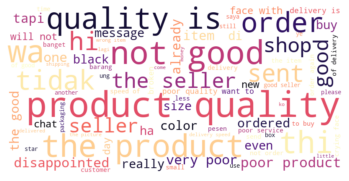

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

rating_1_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', max_words=80).generate(rating_1_text)

plt.imshow(rating_1_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

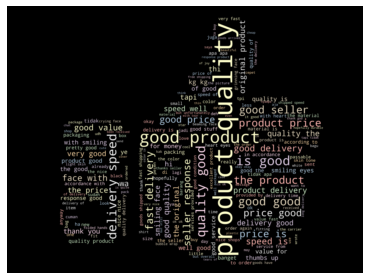

In [27]:
from PIL import Image

# Load image
mask = np.array(Image.open('/kaggle/input/masks/masks-wordclouds/upvote.png'))

rating_3_wordcloud = WordCloud(background_color='black', max_font_size=300, colormap='Pastel1', mask=mask).generate(rating_3_text)

plt.imshow(rating_3_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

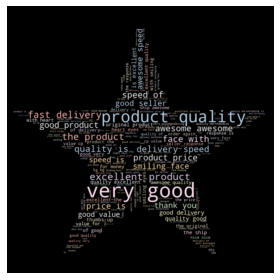

In [28]:
# Load image
mask = np.array(Image.open('/kaggle/input/masks/masks-wordclouds/star.png'))

rating_5_wordcloud = WordCloud(background_color='black', max_font_size=300, colormap='Pastel1', mask=mask).generate(rating_5_text)

plt.imshow(rating_5_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

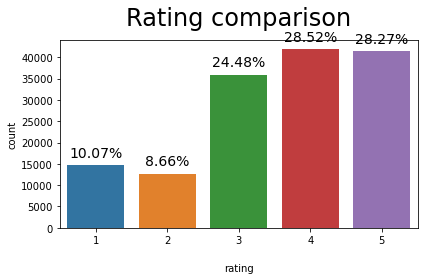

In [29]:
import seaborn as sns

ax = sns.countplot(train_df['rating'])

for val in ax.patches:
    pct = '{:.2f}%'.format(100 * val.get_height() / train_df.shape[0])
    xpos = val.get_x() + val.get_width() / 2.
    ypos = val.get_height()
    ax.annotate(pct, (xpos, ypos), ha='center', va='center', fontsize=14, xytext=(0, 12), textcoords='offset points')
    
plt.title('Rating comparison', fontsize=24, pad=15)
plt.xlabel('rating', labelpad=18)
plt.tight_layout()
plt.show()

In [30]:
!pip install nlpaug -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [31]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [32]:
train_aug =  pd.read_csv('/kaggle/input/text-augmented/review_aug_insert.csv')

print('train aug shape:', train_aug.shape)

train aug shape: (146612, 2)


In [33]:
print('Original:')
print(train_df['review'].loc[12])

print('\nAugmented:')
print(train_aug['review'].loc[12])

print('\nOriginal:')
print(train_df['review'].loc[9])

print('\nAugmented:')
print(train_aug['review'].loc[9])

Original:
very different each photograph tidak realpict

Augmented:
very 150 different image each photograph tidak realpict

Original:
pictures and names of elise 7154 but the brand bg balqis other code x necessarily the same things verry disappointed

Augmented:
pictures and names remain of elise 7154 , but the brand bg balqis other . code x necessarily the same same as things by ver -ry disappointed


In [34]:
train_df = pd.concat([train_df, train_aug], axis=0, ignore_index=True)

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [36]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_masks=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [37]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [38]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [39]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased

In [40]:
# since tf.keras reads your data take 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later(dont forget!!)
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

train_df['rating'] = train_df['rating'].map(rating_mapper_encode)

In [41]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(train_df['rating'], num_classes=5)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.1,
                                                  random_state=2020)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((264018,), (29336,), (264018, 5), (29336, 5))

In [43]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [44]:
MAX_LEN = 192

X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
X_test = regular_encode(test_df['review'].values, tokenizer, maxlen=MAX_LEN)

In [45]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(X_test)
    .batch(BATCH_SIZE)
)

In [46]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 559,895,557
Trainable params: 559,895,557
Non-trainable params: 0
_________________________________________________________________
CPU times: user 2min 8s, sys: 46 s, total: 2min 54s
Wall time: 2min 52s


In [47]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


2062/2062 [==============================] - 927s 450ms/step - loss: 1.1567 - accuracy: 0.4509 - val_loss: 1.0061 - val_accuracy: 0.4992
Epoch 2/4
2062/2062 [==============================] - 893s 433ms/step - loss: 1.0076 - accuracy: 0.5035 - val_loss: 0.9797 - val_accuracy: 0.5151
Epoch 3/4
2062/2062 [==============================] - 895s 434ms/step - loss: 0.9619 - accuracy: 0.5206 - val_loss: 0.9599 - val_accuracy: 0.5234
Epoch 4/4
2062/2062 [==============================] - 900s 436ms/step - loss: 0.9198 - accuracy: 0.5370 - val_loss: 0.9493 - val_accuracy: 0.5293


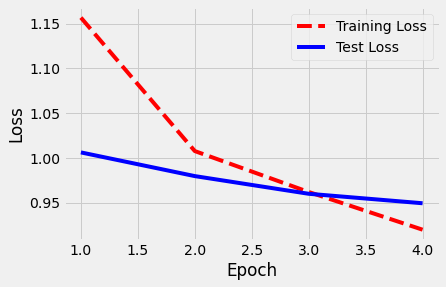

In [48]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [49]:
pred = model.predict(test_dataset, verbose=1)

473/473 [==============================] - 62s 131ms/step


In [50]:
# don't forget to save for ensemble
np.save('xlm-roberta', pred)

In [51]:
pred_sentiment = np.argmax(pred, axis=1)

print(pred_sentiment)

[2 1 3 ... 3 3 3]


In [52]:
submission = pd.DataFrame({'review_id': test_df['review_id'],
                           'rating': pred_sentiment})

In [53]:
submission['rating'] = submission['rating'].map(rating_mapper_decode)

submission.to_csv('submission', index=False)